In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os

In [2]:
path = "./indices_FR_AX/index_asle_AX.txt"

data = pd.read_csv(path, sep=" ", header=None)
data_types = [float, float, float, float, int]
columns = ["LF", "MF", "HF", "Displacement", "Disk"]
data.columns = columns
data

,LF,MF,HF,Displacement,Disk
0,63.135850,100.910003,128.078314,1.0,1.0
1,63.732861,101.725100,127.437836,15.0,3.0
2,63.713974,101.414201,127.741550,7.5,2.0
3,63.697607,101.254199,127.905861,3.5,4.0
4,63.718422,101.484841,126.793883,14.0,1.0
...,...,...,...,...,...
150,63.645495,101.199991,128.017905,1.5,1.0
151,63.712468,101.392559,127.805760,7.0,2.0
152,63.733725,101.740096,127.429785,15.5,3.0
153,63.692493,101.228974,127.897437,3.0,4.0


In [5]:
x_df = data[['LF', 'MF', 'HF']]
y_df_disp = data['Displacement']
y_df_disk = data['Disk']

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(x_df, y_df_disp, random_state=42, test_size=0.20)

print(y_train.shape)
print(y_test.shape)

(124,)
(31,)


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(x_train.columns),))
    first_dense = Dense(units='128', activation='sigmoid')(input_layer)
    second_dense = Dense(units='128', activation='sigmoid')(first_dense)
    third_dense = Dense(units='128', activation='sigmoid')(second_dense)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='Displacement')(third_dense)

    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=y1_output)

    return model

In [11]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer,
              loss={'Displacement': 'mse'},
              metrics={'Displacement': tf.keras.metrics.RootMeanSquaredError()})

In [14]:
history = model.fit(x_train_scaled, y_train,
                    epochs=100, batch_size=10, validation_data=(x_test_scaled, y_test))

Epoch 1/100
13/13 [==============================] - 0s 3ms/step - loss: 0.3985 - root_mean_squared_error: 0.6313 - val_loss: 0.3927 - val_root_mean_squared_error: 0.6266
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 0.3599 - root_mean_squared_error: 0.5999 - val_loss: 0.3619 - val_root_mean_squared_error: 0.6016
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 0.3894 - root_mean_squared_error: 0.6241 - val_loss: 0.3626 - val_root_mean_squared_error: 0.6022
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.3586 - root_mean_squared_error: 0.5988 - val_loss: 0.3601 - val_root_mean_squared_error: 0.6001
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.3772 - root_mean_squared_error: 0.6142 - val_loss: 0.3762 - val_root_mean_squared_error: 0.6133
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 0.3528 - root_mean_squared_error: 0.5939 - val_loss: 0.3787 - val_root_m

In [17]:
# Test the model and print loss and rmse for both outputs
loss, y_rmse = model.evaluate(x=x_test_scaled, y=y_test)

print()
print(f'loss: {loss}')
print(f'rmse: {y_rmse}')

1/1 [==============================] - 0s 14ms/step - loss: 0.3685 - root_mean_squared_error: 0.6071

loss: 0.368539422750473
rmse: 0.607074499130249


In [18]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [22]:
y_test

81      0.5
142     7.5
31      4.0
29      8.0
118    10.0
60     14.0
93      8.5
147    11.0
153     3.0
68     15.0
42      6.5
138     4.0
78      4.5
75      4.0
15      4.5
19      0.5
30     14.0
90      6.5
117     5.5
137    11.0
18     12.0
12      3.0
9       9.5
24      1.5
69      3.5
131     5.0
95     14.5
45      7.5
86      1.5
84      3.0
126     1.0
Name: Displacement, dtype: float64

1/1 [==============================] - 0s 13ms/step


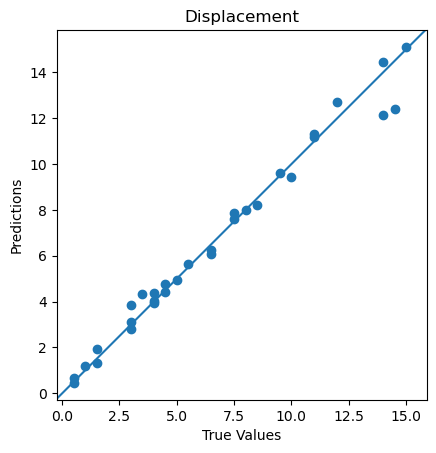

In [25]:
# Run predict
y_pred = model.predict(x_test_scaled)

plot_diff(y_test, y_pred, title='Displacement')